# Introduction to Machine Learning for Physics

![machine](./ml_pic_small_qmap.png)

## Session 2: Linear Classifiers and the Support Vector Machine.

This is the notebook for the second QMAP FSG journal club talk on machine learning and physics applications.

Last time we saw an example of handwritten digit classification using a support vector machine. We then switched gears somewhat and discussed _linear regression_ which tries to learn a collection of labeled data $\{ ( \vec{x}_i , y_i ) \} = \{ ( x_{ij}, y_i ) \}$ via the hypothesis

$$ y_i = \sum_j \beta_j x_{ij} \, , $$

with the $\beta_j$ chosen to minimize the squared error.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/OLS_geometric_interpretation.svg/1280px-OLS_geometric_interpretation.svg.png" alt="genetic" style="width: 350px;"/>

Today I'd like to make contact between those two topics: what does a linear model (like regression) have to do with a **classification task**, like identifying handwritten digits?

One might attempt to generalize what we did last week to the case where our data takes the form $\{ ( \vec{x}_i , y_i ) \}$ where $y_i = \pm 1$. That is, we want to identify whether each data point belongs to class -1 or class 1. We can again make a linear ansatz:

$$ y_i = f \left( \sum_j \beta_j x_{ij} \right) \, , $$

where we choose a step function for $f$,

$$ f ( x_i ) = \begin{cases} 
      1 & \beta_j x_{ij} > \theta \\
      -1 & \text{otherwise} 
   \end{cases} $$

This ansatz is attempting to separate the data points in the two classes by a hyperplane:
   
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Svm_separating_hyperplanes.png/1024px-Svm_separating_hyperplanes.png" alt="genetic" style="width: 350px;"/>

We should keep in mind two, conceptually distinct, motivating examples where learning problems of this form come up.

1. Genuine classification problems, like the handwritten digits example. A general multiclass classification problem, such as taking in an image and spitting out a digit from 0 to 9, can be mapped into a collection of independent binary classification problems via one-vs-rest. Even when the real data is messy and not separable by hyperplanes, the kernel trick for support vector machines can help us cheat and achieve good separation.



2. A classification sub-problem in a larger learning task. Consider a neural network, which is a learning algorithm with the topology of a graph. There is an _input layer_ where we enter an $\vec{x}_i$ and an _output layer_ which predicts one or more $y_i$. Between them are _hidden layers_ which are connected via edges with various weights.

<img src="https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_01_03-DeepNeuralNetwork-WHITEBG.png" alt="genetic" style="width: 500px;"/>

Let's zoom in on a single neuron and freeze what all of the other neurons are doing. This neuron receives a collection of inputs $z_j$ from the neurons in the previous layer. The neuron needs to decide whether to fire, which passes on certain inputs to the neurons in the next layer, or not fire, which passes on zero inputs. One of these two choices will end up leading, far downstream, to better performance in the output layer.

**Therefore each individual neuron in a neural network is a classifier which chooses whether to fire $(y_i = -1)$ or not fire ($y_i = 1$). Further, they are linear classifiers of the type we are discussing.**


So it is important to understand linear classifiers both for their own sake, and for their role in more sophisticated algorithms.


For one final piece of motivation: in understanding the training of a particular linear classifier, the support vector machine, we'll learn about the _primal_ and _dual_ formulations of an optimization problem. This is of independent interest, even outside of classification. One nice example in the context of S-matrix bootstrap is [2102.02847](https://arxiv.org/pdf/2102.02847.pdf).

## Example: Perceptron.

Let's begin with a simple classifier for illustration. First we generate 100 random data points in the plane.

In [184]:
## Import statements
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Make 100 data points and print the first 5
x = np.random.uniform(-5, 5, (100, 2))
print(x[:5])

[[ 0.73211481  2.88239637]
 [-2.30359009 -2.94493196]
 [-4.78513755  3.03353835]
 [ 1.77316916 -4.49748742]
 [-4.132663   -3.68017511]]


In [185]:
y = [1 if pt[0] + 2*pt[1] > 0 else -1 for pt in x]
print(y[:5])

[1, -1, 1, -1, -1]


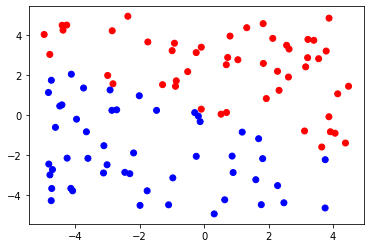

In [186]:
colors = ["r" if pt == 1 else "b" for pt in y]
plt.scatter(x[:, 0], x[:, 1], c = colors)

The data is clearly linearly separable. We'll try to learn the separation using the _perceptron_ algorithm.

1. Initialize all weights $w_i$ to zero.

2. Iterate through the dataset checking whether points are correctly classified.

3. For each mis-classified point $i$, adjust the weight as

$$w_k \to w_k + r x_{ik} ( y_i - \hat{y}_i ) , $$

where $y_i$ is the true value of point $i$ and $\hat{y}_i$ is the current prediction (no sum on $i$). Here $r$ is a constant called the learning rate.

In [187]:
def perceptron(X, Y, start_weights, rate = 0.5, verbose = True):
    w = start_weights.copy()
    
    for i, x in enumerate(X):
        if (np.dot(X[i], w)*Y[i]) <= 0:
            w = w + rate*X[i]*Y[i]
            
            if verbose:
                print("After data point ", i, " weights are ", w)

    return w

In [188]:
w0 = np.zeros(len(x[0]))
w1 = perceptron(x, y, w0)

After data point  0  weights are  [0.3660574  1.44119818]
After data point  21  weights are  [1.9238902  1.03976886]
After data point  27  weights are  [1.0155775  2.13492264]
After data point  37  weights are  [2.02044514 1.65347181]
After data point  61  weights are  [-0.11011253  3.90680887]
After data point  62  weights are  [1.71450875 3.10347195]


We say that the perceptron has _converged_ if there are no misclassifications. We can check that all of the points are correctly classified by running through the perceptron algorithm again until the weights don't change.

In [189]:
wi = w1

for i in range(20):
    new_w = perceptron(x, y, wi, verbose = False)
    
    if np.array_equal(new_w, wi):
        print("Converged on iteration", i)
        break
        
    wi = new_w

Converged on iteration 0


This means that the perceptron correctly classifies all of the points!

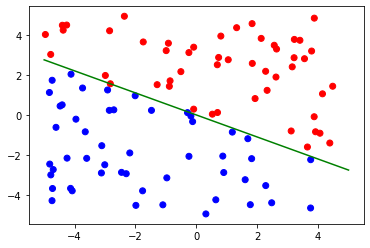

In [190]:
plt.scatter(x[:, 0], x[:, 1], c = colors)

m = -wi[0]/wi[1]
plt.plot([-5, 5], [-5*m, 5*m],'-g')

This algorithm works reasonably well, but has some shortcomings:

1. There is no guarantee that the chosen hyperplane is _optimal_ among the space of separating hyperplanes.
2. If the data is not linearly separable, the perceptron will never converge.
3. The algorithm is stochastic insofar as the result depends on the order in which we train the data and on the learning rate.

These issues are addressed by an improvement called the support vector machine, to which we turn next.